# **자동차 연비 예측 과제**
### **Machine Learning 기말 과제**

---

## **1. 프로젝트 개요**
- **목표**: 자동차의 특성 데이터를 기반으로 연비(MPG)를 예측하는 모델을 구축하고 평가.
- **사용 데이터셋**: UCI Auto MPG Dataset
  - 데이터 출처: [UCI Auto MPG Dataset](https://archive.ics.uci.edu/ml/datasets/auto+mpg)
- **모델 유형**: Dense Layer 기반 신경망 (Deep Neural Network, DNN)
- **과적합 방지 기법**: Early Stopping, Dropout, Regularization, Batch Normalization
- **평가 지표**: Mean Absolute Error (MAE), Mean Squared Errororsepower`) 존재


In [2]:
# 필요한 라이브러리 설치
!pip install pandas numpy matplotlib scikit-learn tensorflow

Defaulting to user installation because normal site-packages is not writeable


In [3]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2


---
## **2. 데이터 준비**
### **2.1. 데이터 로드**
- 데이터는 UCI Auto MPG Dataset에서 제공되며 자동차의 연비(MPG)를 예측하기 위한 특성과 타겟 변수를 포함함.

### **2.2. 데이터 구조 파악**
- 결측치 처리 및 적합한 전처리 방법을 설계하기 위해 데이터 구조를 먼저 파악함

---

In [10]:
# 데이터 로드
file_path =  r"C:\Users\dlwns\OneDrive - 한성대학교\문서\2024 이준구\2학기\머신러닝\기말 과제 자료\auto\auto-mpg.data"
columns = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin', 'car_name']

data = pd.read_csv(file_path, sep=r'\s+', names=columns, na_values='?')


print("\n데이터 샘플 (상위 5개 행):")
print(data.head())

# 통계 요약
print("\n데이터 통계 요약:")
print(data.describe(include='all'))

# 데이터 구조 파악
print("데이터 구조 요약:")
print(data.info())



데이터 샘플 (상위 5개 행):
    mpg  cylinders  displacement  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0  3504.0          12.0   
1  15.0          8         350.0       165.0  3693.0          11.5   
2  18.0          8         318.0       150.0  3436.0          11.0   
3  16.0          8         304.0       150.0  3433.0          12.0   
4  17.0          8         302.0       140.0  3449.0          10.5   

   model_year  origin                   car_name  
0          70       1  chevrolet chevelle malibu  
1          70       1          buick skylark 320  
2          70       1         plymouth satellite  
3          70       1              amc rebel sst  
4          70       1                ford torino  

데이터 통계 요약:
               mpg   cylinders  displacement  horsepower       weight  \
count   398.000000  398.000000    398.000000  392.000000   398.000000   
unique         NaN         NaN           NaN         NaN          NaN   
top            NaN     

---

### **2.3. 데이터 구조 분석**
1. **데이터 크기**:
   - 총 398개의 샘플과 9개의 컬럼이 포함되어 있음.
2. **결측치 확인**:
   - `horsepower` 컬럼에 결측치가 존재함 (NA 값으로 표시됨).
3. **특성별 데이터 유형**:
   - 연속형-float: `mpg`, `displacement`, `horsepower`, `weight`, `acceleration`
   - 범주형-int: `cylinders`, `model_year`, `origin`
   - 텍스트형(제거 대상): `car_name`
4. **타겟 변수**:
   - `mpg`(Miles Per Gallon): 자동차의 연비를 예측하는 타겟 변수.
5. **스케일링 필요성**:
   - 연속형 변수(`weight`, `acceleration` 등) 간의 값 범위 차이가 큼. 정규화가 필요.

---

### **데이터 구조를 파악한 이유**
- 데이터 구조를 파악하여 아래와 같은 전처리 작업을 설계:
  - **결측치(NaN) 처리**: `horsepower`의 결측값을 대체.
  - **범주형 변수 변환**: `origin`을 원-핫 인코딩으로 처리.
  - **불필요한 변수 제거**: `car_name`은 모델 학습에 필요하지 않으므로 제거.
  - **정규화**: 연속형 변수를 `StandardScaler`를 사용해 스케일링.


---

## **3. 데이터 전처리**
### **3.1. 결측치 처리**
- `horsepower` 행에서 결측치를 평균값으로 대체.

### **3.2. 범주형 변수 처리**
- `origin` 행을 One-Hot Encoding으로 변환.

### **3.3. 불필요한 행 제거**
- `car_name` 행 제거.

### **3.4. 데이터 스케일링**
- 모든 연속형 변수를 `StandardScaler`를 사용하여 정규화.

---

### **전처리 코드**


In [5]:
# 결측치 처리: horsepower 결측치는 평균값으로 대체
data['horsepower'] = data['horsepower'].fillna(data['horsepower'].mean())

# 필요 없는 열 제거: car_name 제거
data = data.drop('car_name', axis=1)

# 원-핫 인코딩: origin 열 변환
data = pd.get_dummies(data, columns=['origin'], prefix='origin')

# 독립 변수(X)와 종속 변수(y) 분리
X = data.drop('mpg', axis=1) # mpg를 제외한 나머지 행
y = data['mpg'] # 연비(mpg)를 타겟 변수로 설정

# 데이터 분리: 학습 데이터와 테스트 데이터로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 스케일링: StandardScaler로 데이터를 평균 0, 표준편차 1로 정규화.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("전처리 완료!")


전처리 완료!


**fillna():**

**결측치(NaN)**를 특정 값으로 대체하는 데 사용

**pd.get_dummies**:
pandas 라이브러리에서 제공하는 함수로 범주형 데이터를 원-핫 인코딩으로 변환

**StandardScaler 정의:**
데이터를 평균 0, 표준편차 1로 정규화

**fit_transform():**

**학습 데이터(X_train)**의 평균과 표준편차를 계산하여 스케일링

**transform():**

테스트 데이터(X_test)에 대해 학습 데이터의 평균과 표준편차를 사용하여 변환


---

## **4. 신경망 모델 설계 및 학습**
### **4.1. 모델 설계**
- 2개의 히든 레이어 구성:
  - 각 레이어에 Dropout과 Batch Normalization 추가.
  - L2 정규화를 적용하여 과적합 방지.

### **4.2. Early Stopping**
- 검증 데이터의 손실(`val_loss`)이 10번의 Epoch 동안 개선되지 않을 경우 학습 중단.

---

### **모델 설계 코드**


#### **모델 구성**
1. **첫 번째 Dense Layer**:
   - 뉴런 수: 64
   - 활성화 함수: ReLU
   - 과적합 방지:
     - **L2 정규화** ( lambda = 0.01 )
     - Dropout (30%의 뉴런 비활성화)
     - Batch Normalization
2. **두 번째 Dense Layer**:
   - 뉴런 수: 32
   - 활성화 함수: ReLU
   - 과적합 방지:
     - **L2 정규화** (lambda = 0.01 )
     - Dropout (30%의 뉴런 비활성화)
     - Batch Normalization
3. **출력 레이어**:
   - 뉴런 수: 1 (연속형 출력값 예측)

---
- **Dropout**:
  - 뉴런 간의 과도한 의존성을 줄이기 위해, 학습 중 30%의 뉴런을 랜덤 비활성화.
- **Batch Normalization**:
  - 각 층의 출력값을 정규화하여 학습 안정화 및 속도 향상.
- **L2 정규화**:
  - 가중치 크기를 제어하여 모델의 복잡도를 줄이고 일반화 성능 향상. 이 상황에선 가중치를 0.01로 작게 만들어 과적합을 방지하도록 함.
---
### **모델 컴파일**
#### **1) 최적화 알고리즘: Adam**
- 학습률을 자동으로 조정하며 안정적이고 빠르게 수렴함
#### **2) 손실 함수: MSE (Mean Squared Error)**
- 사용 이유: 연속형 데이터 예측 문제에서 모델의 손실을 효과적으로 측정함
#### **3) 평가 지표: MAE (Mean Absolute Error)**
- 예측값과 실제값의 차이를 절대값으로 변환한 뒤 평균을 계산함
### **모델 설계 코드**


In [17]:
# 신경망 모델 구성
model = Sequential([
    Dense(64, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1],)),
    Dropout(0.3),  # 과적합 방지 & 30%의 뉴런 비활성화
    BatchNormalization(),  # 안정적인 학습
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),  # 과적합 방지 & 30%의 뉴런 비활성화
    BatchNormalization(),  # 안정적인 학습
    Dense(1)  # 출력층// 연속형 값을 예측하므로 활성화 함수 지정 없음(기본: 선형 활성화)
])

# 모델 컴파일
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Early Stopping 정의
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 학습
history = model.fit(
    X_train, y_train,
    epochs=100,             # 최대 Epoch 수
    batch_size=8,           # 한 번에 8개의 샘플을 사용해 가중치를 업데이트
    validation_split=0.2,   # 검증 데이터 비율 20%
    callbacks=[early_stopping]  # early stopping으로 과적합 방지
)

print("모델 학습 완료!")


Epoch 1/100


C:\Users\dlwns\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 567.3781 - mae: 22.4190 - val_loss: 604.2791 - val_mae: 23.4948
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 574.1406 - mae: 22.9546 - val_loss: 577.2375 - val_mae: 23.1095
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 580.2021 - mae: 23.3068 - val_loss: 545.0630 - val_mae: 22.5943
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 521.4168 - mae: 22.1459 - val_loss: 511.7202 - val_mae: 22.0167
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 508.3111 - mae: 22.0232 - val_loss: 472.8537 - val_mae: 21.2593
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 476.5594 - mae: 21.3873 - val_loss: 433.9667 - val_mae: 20.4312
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 450.3200 - mae: 20.6746 - val_loss: 396.1052 - val_mae: 19.5565
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 379.4706 - mae: 18.9482 - val_loss: 355.7929 - val_mae: 18.5274
Epoch 9/100
32/32 ━━━━━━━━━━

## **학습 손실 시각화**
- Training Loss와 Validation Loss 비교
- 학습 손실(Training Loss)과 검증 손실(Validation Loss)을 비교하여 과적합 여부를 확인
- 검증 손실이 학습 손실보다 높아지지 않고 안정적으로 유지됨


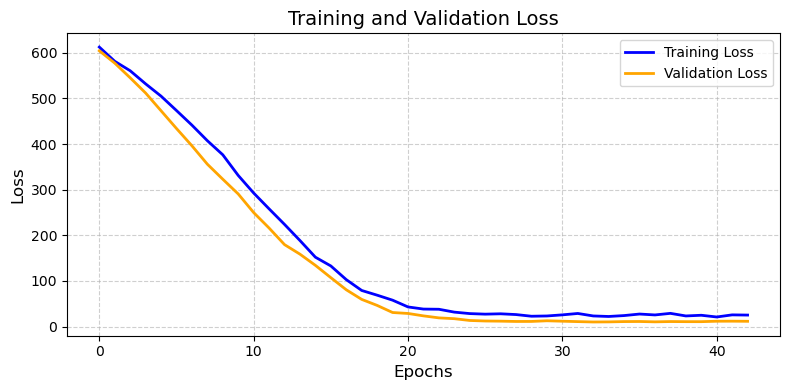

In [18]:
# 학습 손실 시각화 
plt.figure(figsize=(8, 4)) 
plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout() 
plt.show()


---

## **5. 모델 평가**
- **Mean Absolute Error (MAE)**: 평균 절대 오차
- **Mean Squared Error (MSE)**: 평균 제곱 오차
- **R² Score**: 결정 계수, 1에 가까울수록 데이터를 잘 설명함

---

### **평가 코드**


In [8]:
# 모델 평가
y_pred = model.predict(X_test)

# 평가 지표 계산
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"평균 절대 오차 (MAE): {mae:.2f}")
print(f"평균 제곱 오차 (MSE): {mse:.2f}")
print(f"결정 계수 (R²): {r2:.2f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
평균 절대 오차 (MAE): 2.14
평균 제곱 오차 (MSE): 8.27
결정 계수 (R²): 0.85


## **6. 결과 시각화**
* 실제 vs 예측 값
- 실제 연비 값과 모델이 예측한 연비 값을 비교한 결과
- 점들이 빨간 선(y=x)에 가까울수록 모델이 정확히 예측한 것.
---
### **결과 시각화 코드***


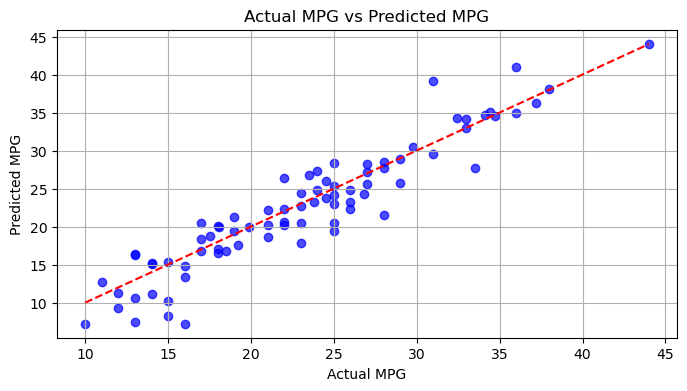

In [19]:
# 실제 값 vs 예측 값
plt.figure(figsize=(8, 4))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('Actual MPG vs Predicted MPG')
plt.xlabel('Actual MPG')
plt.ylabel('Predicted MPG')
plt.grid()
plt.show()


감사합니다!**


---

## **7. 최종 결론**
- **Dense Layer 기반 신경망**을 사용하여 자동차 연비 예측 모델을 성공적으로 구축.
- 과적합 방지 기법을 사용하여 모델의 일반화 향상.
- 시각화를 통해 모델의 예측 성능을 검증.

---

**감사합니다!**
